<a href="https://colab.research.google.com/github/vadaliah/CS5260/blob/master/VWAP%20ML%20Model%20Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forex VWAP(Volume Weighted Average Price) ML Solution
This notebook demonstrates Machine Learning solution to predict VWAP direction for given currency pair based on historical volume dataset

Problem Formulation
In this example, we will use Historical Currencypair price volume dataset provided from FOREX Tester APP, available here: https://forextester.com/data/datasources.
The dataset contains Hourly pricing data of 6 currency pair (EURUSD, GBPUSD, AUDUSD, NZSUSD, USDJPY and USDCHF) for April 2018

Data Dictionary
  1  
 1   Ticker        14327 non-null  object
 2   BusinessDate  14327 non-null  int64  
 3   TimeBucket    14327 non-null  object 
 4   TradeTime     14327 non-null  int64  
 5   TradePrice    14327 non-null  float64
 6   combined1     14327 non-null  object 
 7   Open          13152 non-null  float64
 8   High          13152 non-null  float64
 9   Low           13152 non-null  float64
 10   Close         13152 non-null  float64
 11  AvgPrice      13152 non-null  float64
 12  PV            13152 non-null  float64
 13  VWAP          13152 non-null  float64
 14  Trend         13152 non-null  object 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from google.colab import files
fx_volume_file = 'https://raw.githubusercontent.com/vadaliah/CS5260/master/currencypair_volume_datset.csv'
fx_volume_df = pd.read_csv(fx_volume_file)
fx_volume_df.sample(5)
print(fx_volume_df.shape)
print(fx_volume_df.size)
fx_volume_df.head().values

fx_trade_file = 'https://raw.githubusercontent.com/vadaliah/CS5260/master/trade_dataset.csv'
fx_trade_df = pd.read_csv(fx_trade_file)
print(fx_trade_df.shape)
print(fx_trade_df.size)
fx_trade_df.head().values


(3013, 8)
24104
(14327, 14)
200578


array([['USDJPY', 20180401, '21:00', 2101, 106.167,
        'USDJPY 20180401 21:00', 106.167, 106.268, 106.167, 106.26,
        106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2102, 106.189,
        'USDJPY 20180401 21:00', 106.167, 106.268, 106.167, 106.26,
        106.2155, 106.2155, 106.2155, 'DownTrend'],
       ['USDJPY', 20180401, '21:00', 2105, 106.221,
        'USDJPY 20180401 21:00', 106.167, 106.268, 106.167, 106.26,
        106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2106, 106.219,
        'USDJPY 20180401 21:00', 106.167, 106.268, 106.167, 106.26,
        106.2155, 106.2155, 106.2155, 'UpTrend'],
       ['USDJPY', 20180401, '21:00', 2107, 106.222,
        'USDJPY 20180401 21:00', 106.167, 106.268, 106.167, 106.26,
        106.2155, 106.2155, 106.2155, 'UpTrend']], dtype=object)

In [2]:
	fx_volume_df.info()
	fx_volume_df.columns
	fx_volume_df['Ticker'].value_counts()
	fx_volume_df[['Ticker','BusinessDate','TimeBucket']].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3013 entries, 0 to 3012
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        3013 non-null   object 
 1   BusinessDate  3013 non-null   int64  
 2   TimeBucket    3013 non-null   object 
 3   Open          3013 non-null   float64
 4   High          3013 non-null   float64
 5   Low           3013 non-null   float64
 6   Close         3013 non-null   float64
 7   Volume        3013 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 188.4+ KB


Ticker  BusinessDate  TimeBucket
GBPUSD  20180406      20:00         2
NZDUSD  20180410      20:00         2
USDCHF  20180406      10:00         2
NZDUSD  20180410      10:00         2
        20180427      10:00         2
                                   ..
EURUSD  20180430      18:00         1
                      19:00         1
                      1:00          1
                      20:00         1
USDJPY  20180430      9:00          1
Length: 2831, dtype: int64

In [3]:
	fx_trade_df.info()
	fx_trade_df.columns
	fx_trade_df['Ticker'].value_counts()
	fx_trade_df[['Ticker','BusinessDate','TimeBucket']].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14327 entries, 0 to 14326
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        14327 non-null  object 
 1   BusinessDate  14327 non-null  int64  
 2   TimeBucket    14327 non-null  object 
 3   TradeTime     14327 non-null  int64  
 4   TradePrice    14327 non-null  float64
 5   combined1     14327 non-null  object 
 6   Open          13152 non-null  float64
 7   High          13152 non-null  float64
 8   Low           13152 non-null  float64
 9   Close         13152 non-null  float64
 10  AvgPrice      13152 non-null  float64
 11  PV            13152 non-null  float64
 12  VWAP          13152 non-null  float64
 13  Trend         13152 non-null  object 
dtypes: float64(8), int64(2), object(4)
memory usage: 1.5+ MB


Ticker  BusinessDate  TimeBucket
EURUSD  20180430      10:00         93
NZDUSD  20180420      10:00         93
GBPUSD  20180420      11:00         93
                      10:00         93
EURUSD  20180420      10:00         93
                                    ..
GBPUSD  20180420      5:00          13
EURUSD  20180420      5:00          13
GBPUSD  20180430      5:00          13
AUDUSD  20180430      4:00          13
USDJPY  20180420      5:00          13
Length: 255, dtype: int64

	Exploratory Data Anaysis
	1. Ensure data is complete, verify presence of data for all 6 currency pair is present in the volume dataset
	2. Verify count of data by currencypair, businessdate combination. Any currencypair with insufficient data will skew VWAP results and result in inaccurate model outcome
  3. Verify Trading dataset is complete, contains currency pair and business dates in scope
	

UpTrend      7383
DownTrend    5769
Name: Trend, dtype: int64

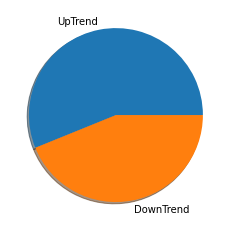

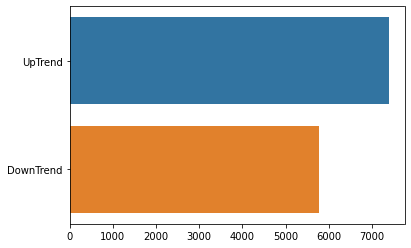

In [20]:
trend_counts =fx_trade_df['Trend'].value_counts()
display(trend_counts)
plt.pie(trend_counts,labels=trend_counts.index,shadow=True )
plt.show()
sns.barplot(y=trend_counts.index, x=trend_counts.values,orient='h')

EURUSD    2878
GBPUSD    2876
AUDUSD    2874
NZDUSD    2853
USDJPY    2846
Name: Ticker, dtype: int64

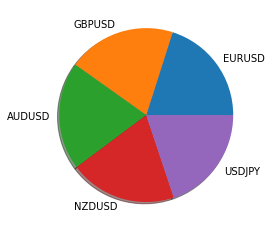

Ticker  BusinessDate
EURUSD  20180430        1440
GBPUSD  20180430        1439
AUDUSD  20180430        1438
NZDUSD  20180430        1436
USDJPY  20180430        1432
AUDUSD  20180420        1260
EURUSD  20180420        1260
GBPUSD  20180420        1260
NZDUSD  20180420        1260
USDJPY  20180420        1258
EURUSD  20180401         178
GBPUSD  20180401         177
AUDUSD  20180401         176
NZDUSD  20180401         157
USDJPY  20180401         156
dtype: int64

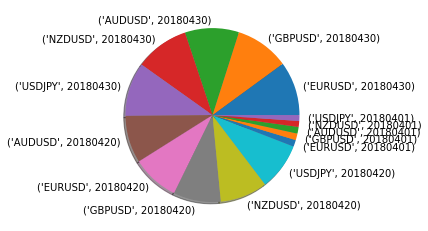

In [16]:
# Plot of Trade Data to visualize currency pair(Ticker) and data count for CurrencyPair, Business Date
ticker_counts =fx_trade_df['Ticker'].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()

ticker_counts =fx_trade_df[['Ticker','BusinessDate']].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()



EURUSD    507
USDJPY    502
USDCHF    502
NZDUSD    502
AUDUSD    500
GBPUSD    500
Name: Ticker, dtype: int64

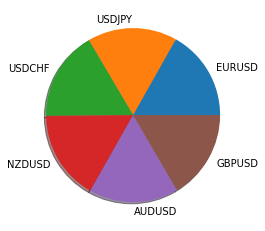

Ticker  BusinessDate
USDJPY  20180430        24
GBPUSD  20180417        24
NZDUSD  20180409        24
        20180405        24
        20180404        24
                        ..
USDCHF  20180401         3
        20180408         3
        20180415         3
        20180422         3
NZDUSD  20180401         3
Length: 156, dtype: int64

NotImplementedError: ignored

In [19]:
# Plot of Volume Data to visualize currency pair(Ticker) 
# Plot of data count for CurrencyPair, Business Date
ticker_counts =fx_volume_df['Ticker'].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()

ticker_counts =fx_volume_df[['Ticker','BusinessDate']].value_counts()
display(ticker_counts)
plt.pie(ticker_counts,labels=ticker_counts.index,shadow=True )
plt.show()
#sns.barplot(y=ticker_counts.index, x=ticker_counts.values,orient='h')